In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

from ema_workbench import ema_logging, load_results
from ema_workbench.analysis import RuleInductionType
from ema_workbench.analysis import scenario_discovery_util as sdutil
from ema_workbench.analysis.prim import pca_preprocess, Prim
from ema_workbench.analysis.cart import CART
from ema_workbench.analysis.feature_scoring import get_ex_feature_scores

from src.config.paths import HAMARAT_DATA_DIR

In [2]:
# === Load results from .tar.gz archive ===
experiments, outcomes = load_results(HAMARAT_DATA_DIR / "10000_lhs.tar.gz")

## Plotting Fraction Renewables and Creating Results Array 


In [3]:
# === Define binary outcome using the final timestep of renewable share ===
fraction_renewables_over_time = outcomes["fraction_renewables"]  # shape (n_runs, 1601)

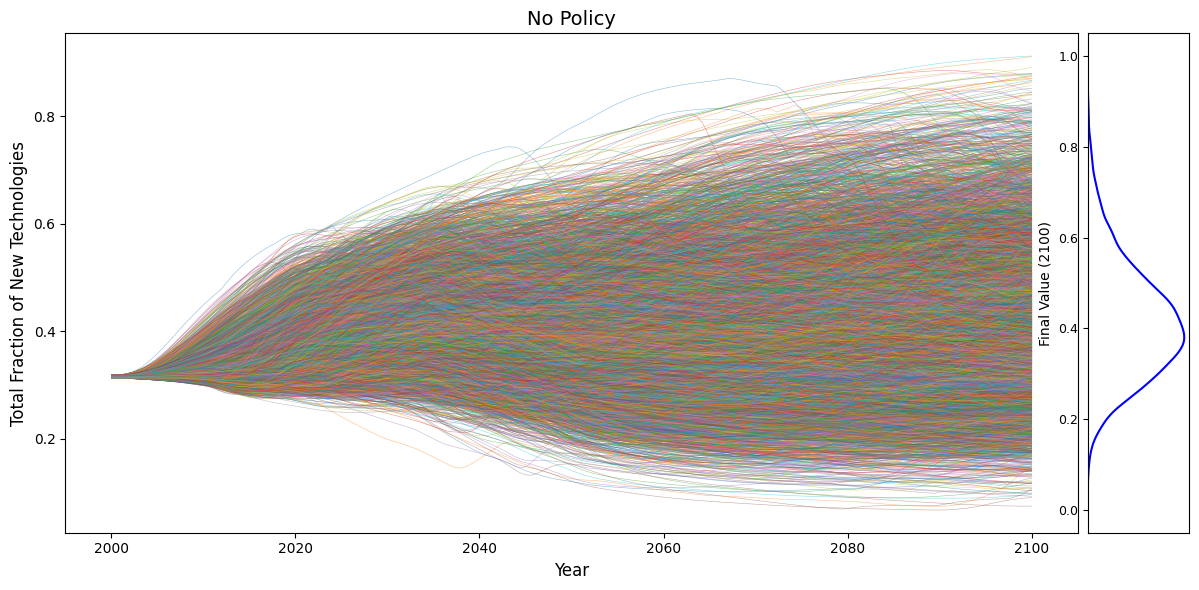

In [4]:
# Time axis from 2000 to 2100 with 0.0625-year resolution
time_resolution = 0.0625
start_year = 2000
end_year = 2100
years = np.arange(start_year, end_year + time_resolution, time_resolution)  # length 1601

# === Plot total fraction of renewables over time ===
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)

for i in range(fraction_renewables_over_time.shape[0]):
    ax.plot(years, fraction_renewables_over_time[i], lw=0.4, alpha=0.5)

ax.set_title("No Policy", fontsize=14)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Total Fraction of New Technologies", fontsize=12)

# === KDE on final year values ===
final_renewable_share = fraction_renewables_over_time[:, -1]
kde = gaussian_kde(final_renewable_share)
y_vals = np.linspace(0, 1, 300)
density = kde(y_vals)

# KDE inset: now with y-axis labels
kde_ax = ax.inset_axes([1.01, 0.0, 0.1, 1.0])  # removed sharey=ax
kde_ax.plot(density, y_vals, color='blue')
kde_ax.set_xticks([])
kde_ax.set_ylabel("Final Value (2100)", fontsize=10)
kde_ax.tick_params(axis='y', labelsize=9)
kde_ax.set_xlim(0, np.max(density) * 1.05)

fig.tight_layout()
plt.show()

In [5]:
final_renewable_share = fraction_renewables_over_time[:, -1]     # year 2100 per run
print(final_renewable_share)

[0.47194096 0.4836969  0.40047872 ... 0.72093546 0.34998903 0.31468686]


## Cleaning the Experiments DataFrame
- Fixing Typo
- Dropping non model input variables
- Setting SWITCH variables to categorical
- Recoding categorical SWITCH variables into dummy variables

In [6]:
# === Correct column name typo ===
if "SWTICH_preference_carbon_curve" in experiments.columns:
    experiments = experiments.rename(columns={"SWTICH_preference_carbon_curve": "SWITCH_preference_carbon_curve"})

# === Drop columns that are not part of the model inputs ===
columns_to_drop = ["model", "policy", "scenario", "year"]
columns_to_drop = [col for col in columns_to_drop if col in experiments.columns]
X_df = experiments.drop(columns=columns_to_drop)

# Convert SWITCH-related columns to categorical
categorical_cols = [col for col in X_df.columns if col.lower().startswith("switch")]
X_df[categorical_cols] = X_df[categorical_cols].astype("category")

# # === Drop all SWITCH-related columns (Because oblique DT algorithms can't handle categorical variables) ===
# switch_cols = [col for col in X_df.columns if col.startswith("SWITCH")]
# X_df = X_df.drop(columns=switch_cols)

In [13]:
# Assume X_df is your DataFrame with categorical SWITCH columns
X_encoded = pd.get_dummies(X_df, drop_first=True)
print(f"Changed categorical variables to dummy variables making the experiments Dataframe gain {X_encoded.shape[1]-X_encoded.shape[1]} columns.")

Changed categorical variables to dummy variables making the experiments Dataframe gain 0 columns.


## Applying Extra Trees Feature Scoring to Determine Features of Interest

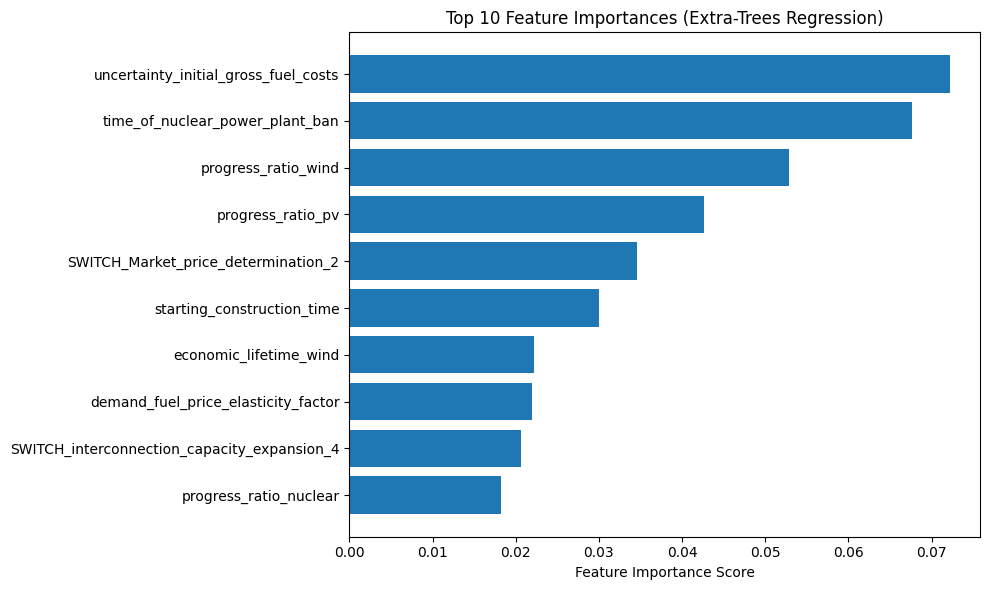

In [14]:
feature_scores_reg, model_reg = get_ex_feature_scores(
    x=X_encoded,
    y=final_renewable_share,
    mode=RuleInductionType.REGRESSION,
    nr_trees=250,
    max_features=None,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True,
    oob_score=True,
    random_state=42
)

top_n = 10
top_features = feature_scores_reg.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features.index, top_features.iloc[:, 0])  # assuming first column is the score
plt.xlabel('Feature Importance Score')
plt.title('Top 10 Feature Importances (Extra-Trees Regression)')
plt.gca().invert_yaxis()  # highest importance on top
plt.tight_layout()
plt.show()

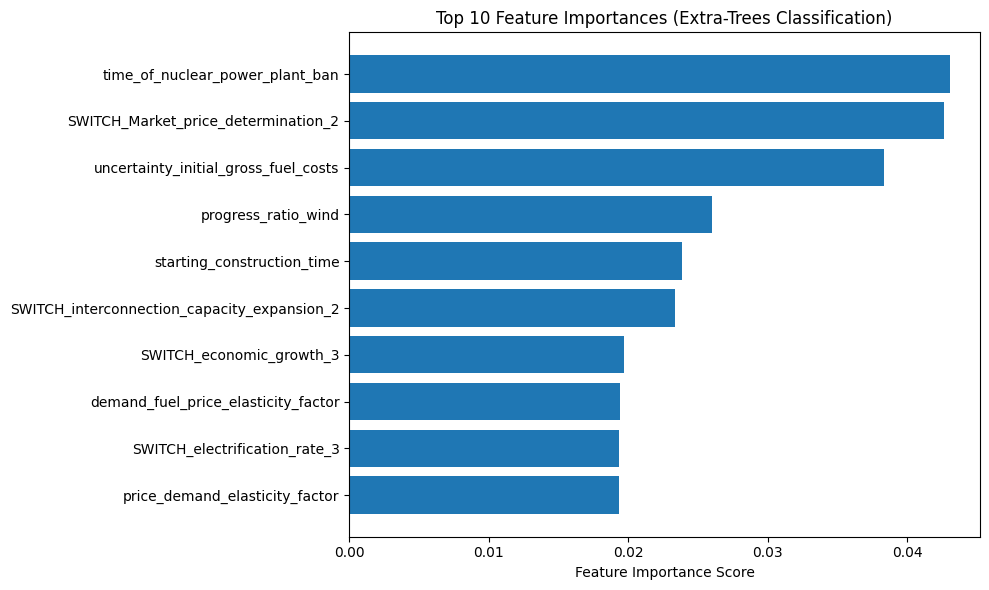

In [17]:
threshold = 0.60
final_renewable_share_binary = (final_renewable_share >= threshold).astype(int)

feature_scores_class, model_class = get_ex_feature_scores(
    x=X_encoded,
    y=final_renewable_share_binary,
    mode=RuleInductionType.CLASSIFICATION,
    nr_trees=250,
    max_features=None,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True,
    oob_score=True,
    random_state=42
)

top_n = 10
top_features_class = feature_scores_class.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features_class.index, top_features_class.iloc[:, 0])  # assuming first column is the score
plt.xlabel('Feature Importance Score')
plt.title('Top 10 Feature Importances (Extra-Trees Classification)')
plt.gca().invert_yaxis()  # highest importance on top
plt.tight_layout()
plt.show()

In [5]:
# === Run PRIM analysis ===
prim_alg = Prim(X_df, y_array, threshold=0.8)
box = prim_alg.find_box()

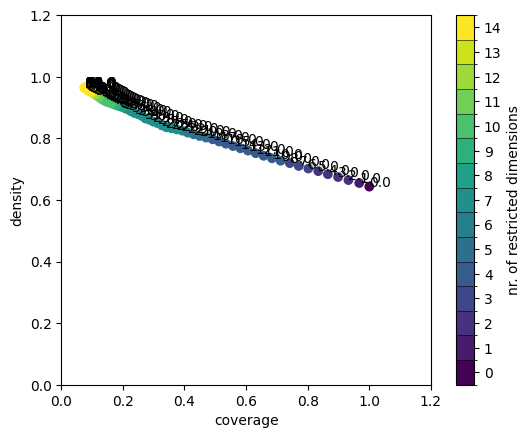

In [14]:
# === Plot trade-off curve ===
box.show_tradeoff(annotated=True)
plt.show()

coverage       0.770953
density        0.710213
id             7.000000
k           4958.000000
mass           0.698100
mean           0.710213
n           6981.000000
res_dim        3.000000
Name: 7, dtype: float64

                                       box 7                               
                                         min         max  qp value qp value
time_of_nuclear_power_plant_ban  2025.439281  2099.99219       0.0      NaN
progress_ratio_wind                  0.86443    0.999999  0.000158      NaN
progress_ratio_pv                   0.764637    0.899996  0.001231      NaN


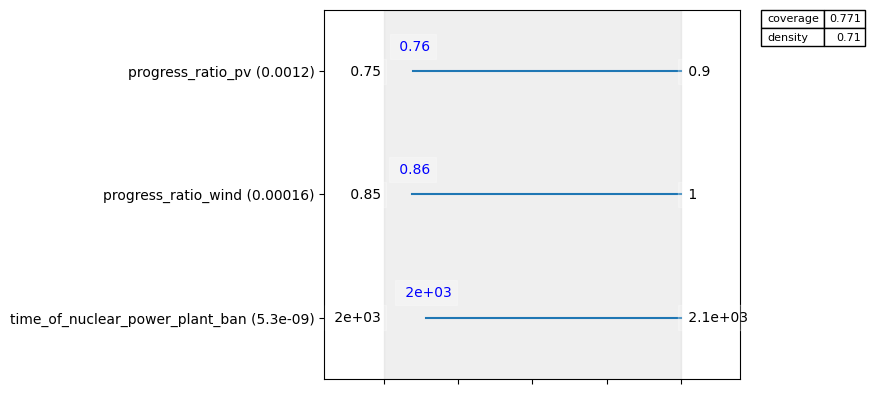

In [15]:
# === Inspect a chosen box ===
chosen_box = 7
box.inspect(chosen_box)                 # Table
box.inspect(chosen_box, style="graph")  # Graph
plt.show()

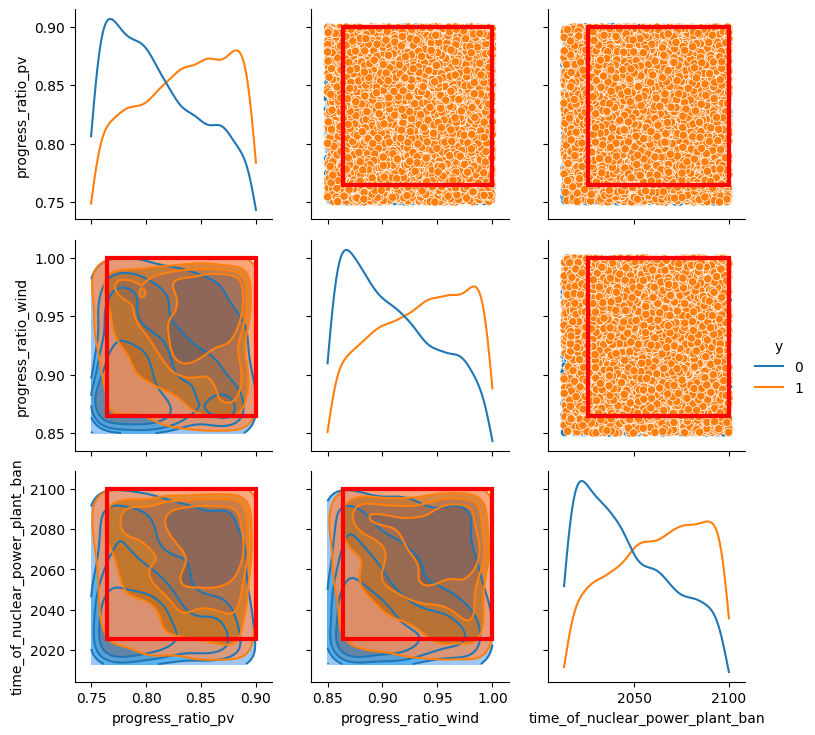

In [16]:
# === Show pairwise scatter for restricted dimensions ===
box.select(chosen_box)
box.show_pairs_scatter()
plt.show()

# Running PCA-PRIM

In [18]:
# PCA preprocessing to rotate the space
X_pca, pca_matrix = pca_preprocess(X_df, y_array)

In [19]:
# Now run PRIM in PCA space (this is PCA-PRIM)
pca_prim = Prim(X_pca, y_array, threshold=0.8)
box = pca_prim.find_box()

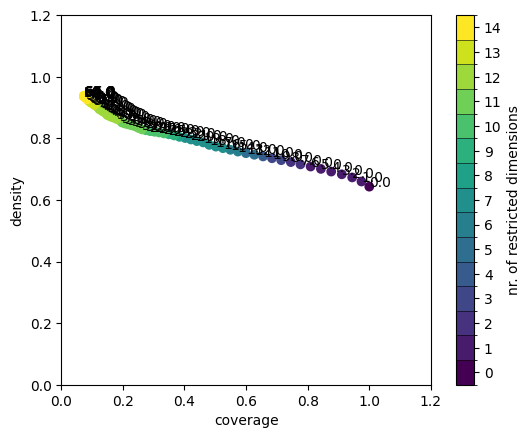

In [20]:
box.show_tradeoff(annotated=True)
plt.show()

coverage       0.876380
density        0.692043
id             4.000000
k           5636.000000
mass           0.814400
mean           0.692043
n           8144.000000
res_dim        1.000000
Name: 4, dtype: float64

    box 4                       
      min  max qp value qp value
r_3  -0.0  0.0      NaN      0.0


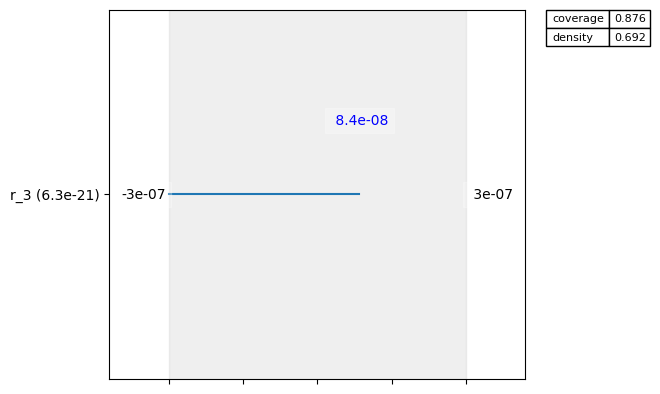

In [21]:
chosen_box_pca_prim = 4 # Select box 4 for further analysis

box.inspect(chosen_box_pca_prim)                  # textual
box.inspect(chosen_box_pca_prim, style="graph")   # graphical
plt.show()

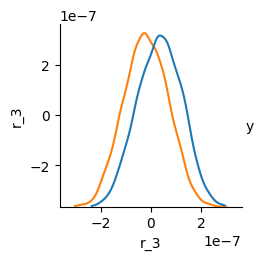

In [22]:
box.select(chosen_box_pca_prim)
box.show_pairs_scatter()
plt.show()

# Running CART

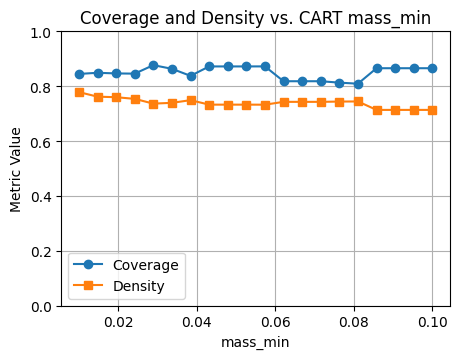

In [32]:
def get_predicted_label_for_each_box(cart_model: CART):
    """Returns the predicted class for each terminal box (leaf)."""
    clf = cart_model.clf
    values = clf.tree_.value  # shape (n_nodes, 1, n_classes)
    classes = clf.classes_
    is_leaf = clf.tree_.children_left == -1

    labels = []
    for i in range(len(is_leaf)):
        if is_leaf[i]:
            class_counts = values[i][0]
            predicted_class = classes[np.argmax(class_counts)]
            labels.append(predicted_class)
    return labels


def compute_cart_coverage_density(cart_model: CART, X_df, y_array, positive_class=1):
    boxes = cart_model.boxes
    labels = get_predicted_label_for_each_box(cart_model)

    total_positive = np.sum(y_array == positive_class)
    mask_union = np.zeros(len(X_df), dtype=bool)

    for box, label in zip(boxes, labels):
        if label != positive_class:
            continue
        mask = sdutil._in_box(X_df, box)
        mask_union |= mask

    selected_y = y_array[mask_union]
    coverage = np.sum(selected_y == positive_class) / total_positive if total_positive > 0 else 0
    density = np.sum(selected_y == positive_class) / len(selected_y) if len(selected_y) > 0 else 0

    return coverage, density


# === Sweep mass_min values ===
mass_min_values = np.linspace(0.01, 0.1, 20)
coverages = []
densities = []

for mass_min in mass_min_values:
    cart_model = CART(X_df, y_array, mass_min=mass_min)
    cart_model.build_tree()
    coverage, density = compute_cart_coverage_density(cart_model, X_df, y_array)
    coverages.append(coverage)
    densities.append(density)

# === Plotting ===
plt.figure(figsize=(4.7, 3.7))
plt.plot(mass_min_values, coverages, label="Coverage", marker='o')
plt.plot(mass_min_values, densities, label="Density", marker='s')
plt.ylim(0, 1)
plt.xlabel("mass_min")
plt.ylabel("Metric Value")
plt.title("Coverage and Density vs. CART mass_min")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
# === Run CART ===
cart_alg = CART(X_df, y_array, mass_min=0.05)
cart_alg.build_tree()

# === Print stats and box limits ===
print("CART Box Stats:")
print(pd.DataFrame(cart_alg.stats))

CART Box Stats:
    coverage   density  res dim    mass
0   0.074172  0.557243        3  0.0856
1   0.093765  0.745365        3  0.0809
2   0.065153  0.692562        3  0.0605
3   0.065464  0.753131        4  0.0559
4   0.077282  0.826955        5  0.0601
5   0.096875  0.943939        6  0.0660
6   0.067797  0.872000        6  0.0500
7   0.015083  0.190945        4  0.0508
8   0.029389  0.369863        4  0.0511
9   0.036075  0.381579        4  0.0608
10  0.053957  0.606643        4  0.0572
11  0.047427  0.424200        4  0.0719
12  0.092365  0.652747        4  0.0910
13  0.064376  0.656101        4  0.0631
14  0.120821  0.817035        4  0.0951


In [34]:
def get_predicted_label_for_each_box(cart_model: CART):
    """Returns a list of predicted labels for each terminal leaf box."""
    clf = cart_model.clf
    values = clf.tree_.value  # shape (n_nodes, 1, n_classes)
    classes = clf.classes_    # class labels (e.g., [0, 1])

    left = clf.tree_.children_left
    is_leaf = left == -1

    labels = []
    for i in range(len(is_leaf)):
        if is_leaf[i]:
            class_counts = values[i][0]
            predicted_class = classes[np.argmax(class_counts)]
            labels.append(predicted_class)
    return labels

In [35]:
def compute_cart_coverage_density(cart_model: CART, X_df, y_array, positive_class=1):
    boxes = cart_model.boxes
    stats = cart_model.stats
    labels = get_predicted_label_for_each_box(cart_model)

    total_positive = np.sum(y_array == positive_class)
    mask_union = np.zeros(len(X_df), dtype=bool)

    for box, label in zip(boxes, labels):
        if label != positive_class:
            continue
        mask = sdutil._in_box(X_df, box)
        mask_union |= mask

    selected_y = y_array[mask_union]

    coverage = np.sum(selected_y == positive_class) / total_positive if total_positive > 0 else 0
    density = np.sum(selected_y == positive_class) / len(selected_y) if len(selected_y) > 0 else 0

    return coverage, density

In [36]:
cart_alg = CART(X_df, y_array, mass_min=0.05)
cart_alg.build_tree()

coverage, density = compute_cart_coverage_density(cart_alg, X_df, y_array)
print(f"Coverage: {coverage:.3f}")
print(f"Density: {density:.3f}")

Coverage: 0.872
Density: 0.733
